In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [25]:
class Path_Segment:
    def __init__(self, pa, pb, tp):
        if tp == "circle":
            # pa = center of circle
            # pb = [theta_0, theta_1, radius]
            self.p_c = pa
            self.theta_0 = pb[0]
            a_d = pb[1] - p[0] # angular distance
            self.t2theta = a_d
            D = a_d * pb[2] # distance in meters
            self.radius = pb[2]
            self.d2t = 1.0 / D 
        
        elif tp == "line":
            self.p0 = pa
            diff = pb - pa
            self.D = np.linalg.norm(diff)
            self.delta == diff / D
            self.d2t = 1.0/D
            self.tp = tp
        else:
            print("Path_Segment: __init__: Bad Type: ", tp)
    
    def step(self, dist):
        if self.tp == "circle":
            return self.step_circle(dist)
        elif self.tp == "line":
            return self.step_line(dist)
        else:
            print("Path_Segment: Step: Bad Type: ", self.tp)
    
    def step_circle(self, dist):
        # distance here is in meters, need to convert to t
        self.t += dist * self.d2t
        if self.t > 1.0:
            # off segment - treat as a line!
            ex_d = (self.t - 1.0) / self.d2t
            return [False, ex_d]
        else:
            # on arc, step along arc - get angular position
            ang = self.theta_0 + self.t * self.t2theta
            # find point on edge of circle
            p_t = np.array([self.p_c + self.r * math.cos(ang), self.p_c + self.r * math.sin(ang)])
            return [True, p_t]
        
    def step_line(self, dist):
        self.t += dist * self.d2t
        if self.t > 1.0:
            # off segment
            ex_d = (self.t - 1.0) / self.d2t
            return [False, ex_d]
        else:
            # still on segment, keep going!
            p_t = self.p0 + self.t * self.delta
            return [True, p_t]

class Path:
    path_index = 0
    def __init__(self):
        pass
        
        
    def step(self, dist):
        [success, pnt] = self.segments[self.path_index].step(dist)
        if success:
            return [True, pnt]
        elif self.path_index + 1 < self.N_path_segments:
            # can move onto the next segment, increment segment counter and try again
            self.path_index += 1
            self.step(dist)
        else:
            # reached end of path, kill it
            return [False, -1]
            
            
        
        

In [26]:
# useful functions
def update_m_per_deg(latMid):
    latMid = latMid * math.pi / 180.0
    m_per_deg_lat = 111132.92 - 559.82*math.cos(2*latMid) + 1.175*math.cos(4*latMid) - 0.002*math.cos(6*latMid)
    m_per_deg_lon = 111412.84*math.cos(latMid) - 93.5*math.cos(3*latMid) + 0.118*math.cos(5*latMid)
    print("Updated meters per degree: ",[m_per_deg_lon, m_per_deg_lat])
    return [m_per_deg_lat, m_per_deg_lon]
    
def latLonToXY(mean_lla, lla_p, m_per_deg):
    # assumes ENU -> dLon -> x, dLat ->y
    # A = [39.510099961976394, -119.79924744019958]
    # B = [39.52450022763636, -119.83225271498078]
    # Dist = 3.26 km per Google and 3257.53m per this, call it Google rounding...
    dLon = lla_p[1] - mean_lla[1]
    dLat = lla_p[0] - mean_lla[0]
    dx = m_per_deg[1] * dLon
    dy = m_per_deg[0] * dLat
    return [dx,dy]

def dist2d(self, diffs):
    return np.linalg.norm([diffs])

Steve's backyard:
    1. North-East Corner of yard: 39.43967416004803, -119.78459796691637
    2. North-West Corner of Yard: 39.43962877630515, -119.78397292268954
    3. South-East Corner of Yard: 39.43898239857549, -119.78458728239967
    4. South-West Corner of Yard: 39.43899477607771, -119.78402990677858
        1. Add geo-fence points 5m inside of this
        2. Add corner points 10m inside of that w/ 5 m radius
            1. Goal is to be 10m from edge and 5 m from geo-fence

In [27]:
# NE, NW, SE, SW
corners_lla = [[39.43967416004803, -119.78459796691637],
               [39.43962877630515, -119.78397292268954],
               [39.43898239857549, -119.78458728239967],
               [39.43899477607771, -119.78402990677858]]
corners_lla = np.asarray(corners_lla)
mean_lla = np.mean(corners_lla, axis=0)
print("mean lla: ", mean_lla)
m_per_deg = update_m_per_deg(mean_lla[0])

mean lla:  [  39.43932003 -119.78429702]
Updated meters per degree:  [86088.13142758049, 111023.85109608833]


In [28]:
# convert to meters!
corners_m = []
for c in corners_lla:
    corners_m.append(latLonToXY(mean_lla, c, m_per_deg))

corners_m = np.asarray(corners_m)

Now we need to set the geofence 5m insdie the boundary of each corner

In [29]:
# add the geofence
gf_d = 5.0 # distance from wall
gf_pts = corners_m.copy()
gf_pts[0,:] += [gf_d,-gf_d]
gf_pts[1,:] += [-gf_d,-gf_d]
gf_pts[2,:] += [gf_d,gf_d]
gf_pts[3,:] += [-gf_d,gf_d]

Now identify the corner points we're going to move around

In [33]:
# make the centers of the circle we're going to drive around
c_d = 10.0 # offset from the geofence
c_pts = gf_pts.copy()
c_pts[0,:] += [c_d,-c_d]
c_pts[1,:] += [-c_d,-c_d]
c_pts[2,:] += [c_d,c_d]
c_pts[3,:] += [-c_d,c_d]
c_pts

array([[-10.90798386,  24.31713135],
       [ 12.90090569,  19.27845344],
       [ -9.98817378, -22.48489137],
       [  7.99525194, -21.11069341]])

Next we need to identify the outer tangential lines to the circles defined by c_pts and radius of 5m

In [34]:
# first get distance between two circle centers
pts = [0, 1]
rs = [5,5]

xs = [c_pts[pts[0],0], c_pts[pts[1],0]]
ys = [c_pts[pts[0],1], c_pts[pts[1],1]]

# if r[0] == r[1] there is a shortcut because the outer tangent lines are parallel and the distance between them is 2r
if rs[0] == rs[1]:
    # radii are equal!
    # slope angle is:
    theta = math.atan((ys[1]- ys[0])/(xs[1]-xs[0]))
#     xs_i = [[xs[0]+rs[0]*math.sin(theta), xs[0]-rs[0]*math.sin(theta)],
#             [xs[1]+rs[1]*math.sin(theta), xs[0]-rs[1]*math.sin(theta)]]
#     ys_i = [[ys[0]+rs[0]*math.cos(theta), ys[0]-rs[0]*math.cos(theta)],
#             [ys[1]+rs[1]*math.cos(theta), ys[0]-rs[1]*math.cos(theta)]]
    ps_i = [[xs[0]-rs[0]*math.sin(theta), ys[0]+rs[0]*math.cos(theta)],
            [xs[0]+rs[0]*math.sin(theta), ys[0]-rs[0]*math.cos(theta)],
            [xs[1]-rs[1]*math.sin(theta), ys[1]+rs[1]*math.cos(theta)],
            [xs[1]+rs[1]*math.sin(theta), ys[1]-rs[1]*math.cos(theta)]]
    
    # identify  the lines that are the outer outer tangent line using distance to the middle of the lines from the center
    # line 1 := ps_i[0,:] -> ps_i[2,:]
    # line 2 := ps_i[1,:] -> ps_i[3,:]
    
    # calculate angular position along each circle
    # get parametric line equation of outer outer tanget
    
    

ps_i = np.asarray(ps_i)

    
D = np.linalg.norm(c_pts[pts[0],:] - c_pts[pts[1],:])
# the outer tangent lines intersection points is found using the radius of the two circles. This assumes r0 > r1



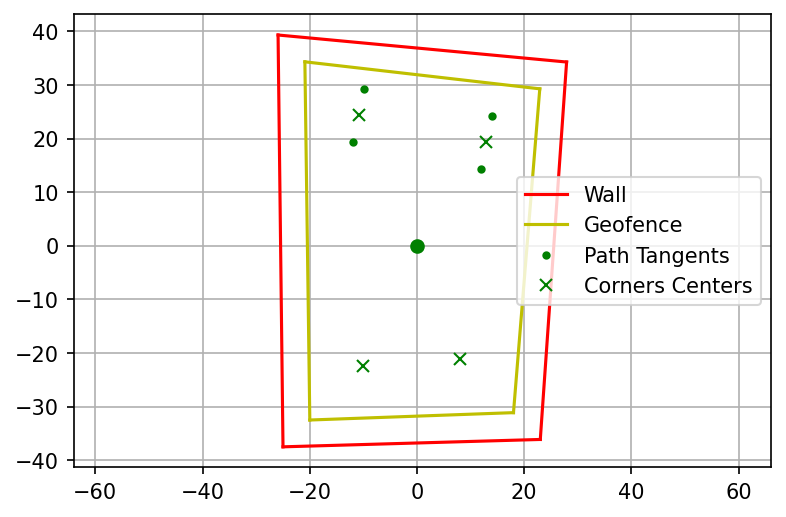

In [36]:
plt.figure(dpi=150)
# plot hard limits
plt.plot([corners_m[0,0], corners_m[1,0]],[corners_m[0,1],corners_m[1,1]], 'r', label="Wall")
plt.plot([corners_m[1,0], corners_m[3,0]],[corners_m[1,1],corners_m[3,1]], 'r', label="_Wall")
plt.plot([corners_m[3,0], corners_m[2,0]],[corners_m[3,1],corners_m[2,1]], 'r', label="_Wall")
plt.plot([corners_m[2,0], corners_m[0,0]],[corners_m[2,1],corners_m[0,1]], 'r', label="_Wall")

plt.plot([gf_pts[0,0], gf_pts[1,0]],[gf_pts[0,1],gf_pts[1,1]], 'y', label="Geofence")
plt.plot([gf_pts[1,0], gf_pts[3,0]],[gf_pts[1,1],gf_pts[3,1]], 'y', label="_Geofence")
plt.plot([gf_pts[3,0], gf_pts[2,0]],[gf_pts[3,1],gf_pts[2,1]], 'y', label="_Geofence")
plt.plot([gf_pts[2,0], gf_pts[0,0]],[gf_pts[2,1],gf_pts[0,1]], 'y', label="_Geofence")

plt.plot(ps_i[:,0], ps_i[:,1], 'g.', label="Path Tangents")

plt.plot(c_pts[:,0], c_pts[:,1], 'gx', label="Corners Centers")

plt.plot(0,0,'go')
plt.axis('equal')
plt.legend()
plt.grid()